In [17]:
# import hist_eq
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from math import log10, sqrt 


DAY_IMG_PATH = 'data/DSC_0232.JPG'
NIGHT_IMG_PATH = 'data/DSC_0214.JPG'

# Task 2.2.1: Histogram Equalization

In [18]:
# This cell contains the functions used and their descriptions
def mean_squared_error(x1, x2):
    '''
    Used to calculate the mse between original image and our implementation
    '''
    return np.mean(np.square(x1 - x2))


def psnr(x1, x2): 
    '''
    Peak Signal to Noise Ratio
    '''
    mse = mean_squared_error(x1, x2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 


def calc_cdf(count):
    '''
    Calculating the cumulative density function
    '''
    cdf = np.cumsum(count) / sum(count)
    return cdf


def histogram_equalization_channel(image:np.ndarray, nbins=255):
    '''
    Applying histogram equalization to a single image channel
    For our case we applied it to the Y channel in Y'UV color space
    '''
    hist, bin_centers = np.histogram(image.ravel(), bins=nbins)
    cdf = calc_cdf(hist)

    flattened_img = image.ravel()
    out = []
    for pix in flattened_img:
        out.append(cdf[pix-1])

    out = (np.array(out).reshape(image.shape) * 255).astype('uint8')
    return out 


def histogram_equalization(img:np.ndarray):
    '''
    Our Method for applying histogram equalization
    '''
    # ? Converting from BGR color space to YUV color space
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # ? Applying histogram equalization to the Y' channel
    img_yuv[:,:,0] = histogram_equalization_channel(img_yuv[:,:,0])

    # ? Converting back to BGR 
    out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return out 



def plot_histogram(channel_intensities:np.ndarray, title:str, save=True):
    '''
    Helper function to plot the intensities of an image channel
    Takes in HxW matrix and plots and saves it
    '''
    hist, bins = np.histogram(channel_intensities.ravel(), bins=256, range=(0,256))
    cdf = hist.cumsum()
    cdf_norm = cdf * float(hist.max()) / cdf.max()


    plt.hist(channel_intensities.ravel(), bins=256, range=(0,255))
    plt.stairs(cdf_norm)
    plt.title(title)
    plt.xlim([0, 256])
    plt.xlabel('pixel intensities')
    plt.ylabel('frequency')
    plt.legend(('cdf','histogram'), loc = 'upper left')
    if save:
        plt.savefig(f'data/{title}.png')

    plt.show()


def equalize_histogram_cv(img:np.ndarray):
    '''
    Applying Histogram equalization using OpenCV function
    '''
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return out

def resize_with_aspect_ratio(image, width=None, height=None):
    '''
    Helper function to decrease the resolution of images to decrease storage space
    Overleaf only allows 50MB max upload
    '''
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = w / h

    if width is None:
        # Calculate height based on the specified width
        new_height = int(height / aspect_ratio)
        resized_image = cv2.resize(image, (height, new_height))
    else:
        # Calculate width based on the specified height
        new_width = int(width * aspect_ratio)
        resized_image = cv2.resize(image, (new_width, width))

    return resized_image

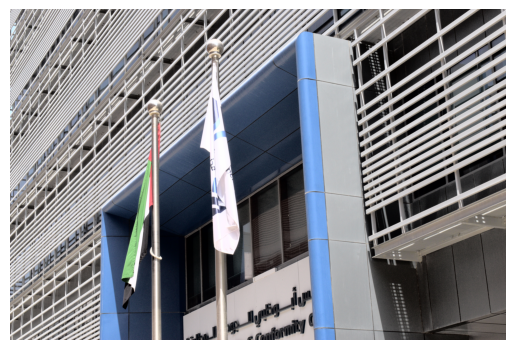

In [19]:
# Applying Histogram Equalization to day time image
img = cv2.imread(DAY_IMG_PATH)
hist_equalized = histogram_equalization(img)

# ? The following line saves our output img
cv2.imwrite('data/our_histogram_output.png', hist_equalized)

plt.imshow(cv2.cvtColor(hist_equalized, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [20]:
# Applying Histogram Equalization to night time image
img2 = cv2.imread(NIGHT_IMG_PATH)
hist_equalized2 = histogram_equalization(img2)

# ? The following line saves our output img, Downscaling to save below 5MB
cv2.imwrite('data/our_histogram_output2.png', 
            resize_with_aspect_ratio(hist_equalized2, height=5000))

plt.imshow(cv2.cvtColor(hist_equalized2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

KeyboardInterrupt: 

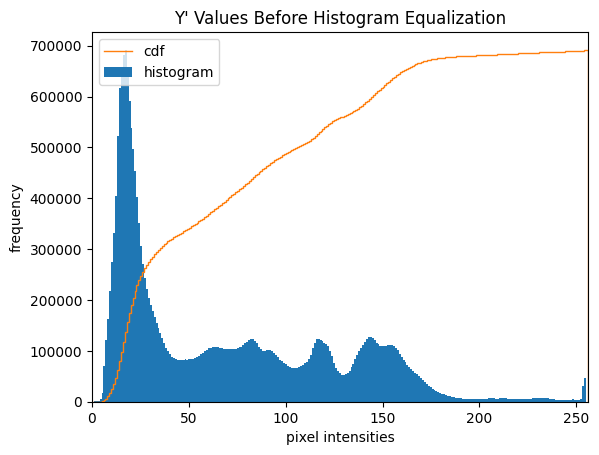

In [5]:
# ? Plotting Luminance before equalization
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
plot_histogram(img_yuv[:, :, 0], "Y' Values Before Histogram Equalization")


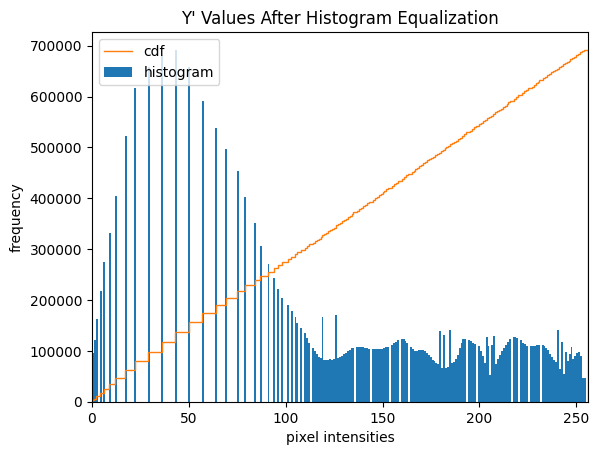

In [6]:
# ? Plotting Luminance after equalization
plot_histogram(
    histogram_equalization_channel(
        img_yuv[:,:,0]
    ), "Y' Values After Histogram Equalization"
)


In [7]:
# ? Comparing with OpenCV
cv2_result = equalize_histogram_cv(img)
res = np.hstack((hist_equalized,cv2_result))

# ? Resizing to decrease storage size
cv2.imwrite('data/histogram_compare_with_cv2.png', resize_with_aspect_ratio(res, height=6000))




print(f'Mean Square Error: {mean_squared_error(hist_equalized, cv2_result):.2f}')
print(f'PSNR: {psnr(hist_equalized, cv2_result):.2f} db')


Mean Square Error: 15.15
PSNR: 36.33 db


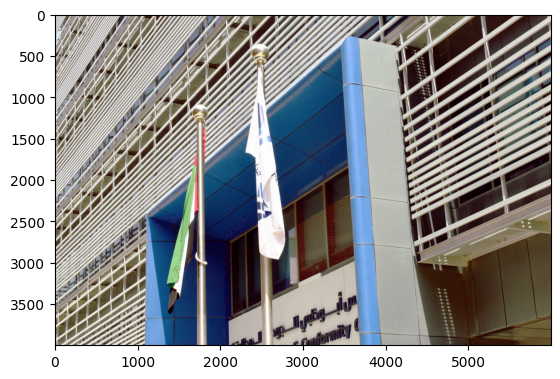

In [8]:
# Ablation Study: Applying Histogram Equalization to individual RGB channels
# ? [TAKES AROUND A MINUTE TO RUN]
img = cv2.imread(DAY_IMG_PATH)

def histogram_equalization_rgb(img:np.ndarray):
    img[:,:,0] = histogram_equalization_channel(img[:,:,0])
    img[:,:,1] = histogram_equalization_channel(img[:,:,1])
    img[:,:,2] = histogram_equalization_channel(img[:,:,2])

    return img 


img_rgb_hist = histogram_equalization_rgb(img)
cv2.imwrite('data/rgb_equalized_img_day.png', img_rgb_hist)
plt.imshow(
    cv2.cvtColor(img_rgb_hist, cv2.COLOR_BGR2RGB)
)
plt.show()





# Task 2.2.2 Contrast Stretching

**Function to perform linear piece-wise contrast stretching**

In [9]:
def contrast_stretch(channel, a1, a2, b1, b2, L=256):
    output_image = np.zeros(channel.shape, dtype=np.uint8)

    #0 to alpha1
    output_image[channel <= a1] = (b1 / a1) * channel[channel <= a1]

    #alpha1 to alpha2
    mask = (channel > a1) & (channel <= a2)
    output_image[mask] = ((b2 - b1) / (a2 - a1)) * (channel[mask] - a1) + b1

    #alpha2 to L-1
    output_image[channel > a2] = ((L-1 - b2) / (L-1 - a2)) * (channel[channel > a2] - a2) + b2

    return output_image

**Load and split RGB image**

In [10]:
img = cv2.imread(DAY_IMG_PATH)

#BGR to RGB
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#split rgb channels
channels = cv2.split(rgb_img)

**Applying contrast stretching**

In [11]:
#set alpha and beta values
a1, a2 = 30, 180
b1, b2 = 10, 220

#apply contrast stretching on the channels separately
cont_stretched_channels = [contrast_stretch(channel, a1, a2, b1, b2) for channel in channels]

#merge the three stretched channels
stretched_img_rgb = cv2.merge(cont_stretched_channels)

**Display original and contrast stretched images**

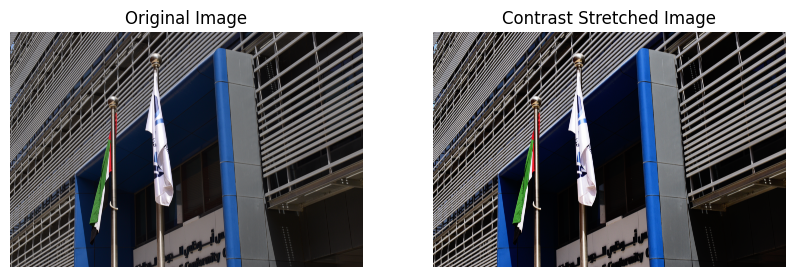

True

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(stretched_img_rgb)
plt.title('Contrast Stretched Image')
plt.axis('off')
plt.show()

#convert rgb to bgr to save image using openCV
stretched_img_bgr = cv2.cvtColor(stretched_img_rgb, cv2.COLOR_RGB2BGR)
cv2.imwrite("stretched_image_day.png", stretched_img_bgr)

**Histograms for each channel are plotted to observe the change**

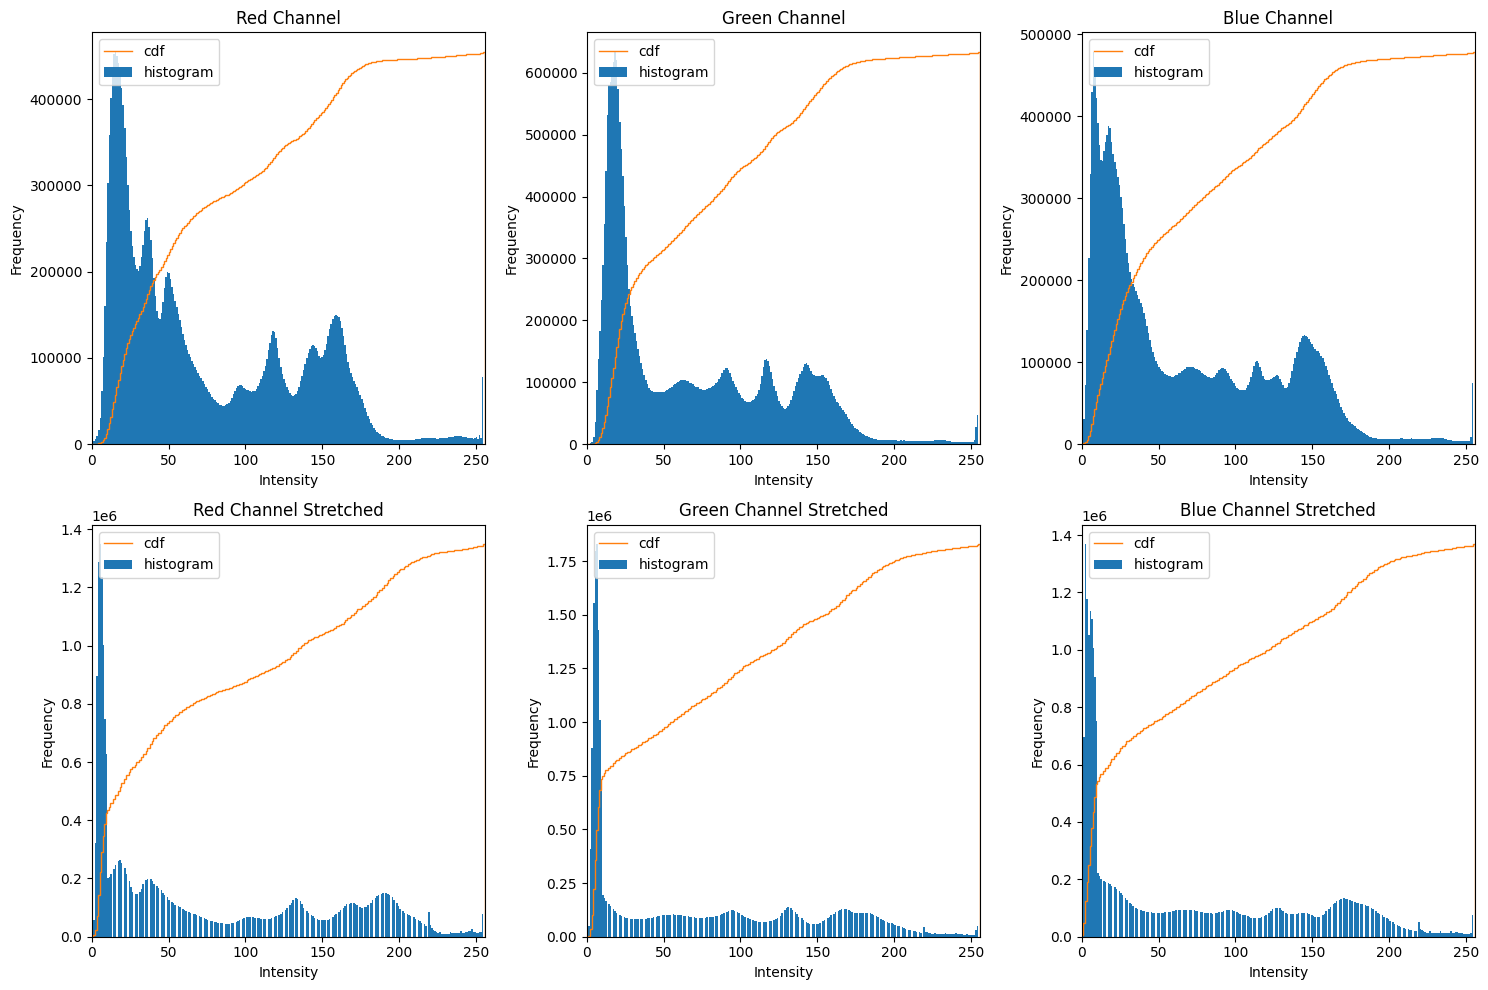

In [13]:
def plot_histogram(channel_intensities: np.ndarray, title: str, ax):
    hist, bins = np.histogram(channel_intensities.ravel(), bins=256, range=(0, 256))
    cdf = hist.cumsum()
    cdf_norm = cdf * float(hist.max()) / cdf.max()

    ax.hist(channel_intensities.ravel(), bins=256, range=(0, 255))
    ax.stairs(cdf_norm)
    ax.set_title(title)
    ax.set_xlim([0, 256])
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Frequency')
    ax.legend(('cdf', 'histogram'), loc='upper left')

channels = cv2.split(rgb_img)
blue_channel_img = channels[0]
green_channel_img = channels[1]
red_channel_img = channels[2]

channels_stretched = cv2.split(stretched_img_rgb)
blue_channel_img_stretched = channels_stretched[0]
green_channel_img_stretched = channels_stretched[1]
red_channel_img_stretched = channels_stretched[2]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_histogram(red_channel_img, 'Red Channel', axs[0, 0])
plot_histogram(green_channel_img, 'Green Channel', axs[0, 1])
plot_histogram(blue_channel_img, 'Blue Channel', axs[0, 2])

plot_histogram(red_channel_img_stretched, 'Red Channel Stretched', axs[1, 0])
plot_histogram(green_channel_img_stretched, 'Green Channel Stretched', axs[1, 1])
plot_histogram(blue_channel_img_stretched, 'Blue Channel Stretched', axs[1, 2])

plt.tight_layout()
plt.show()


**Trying out different values of Alpha and Beta**

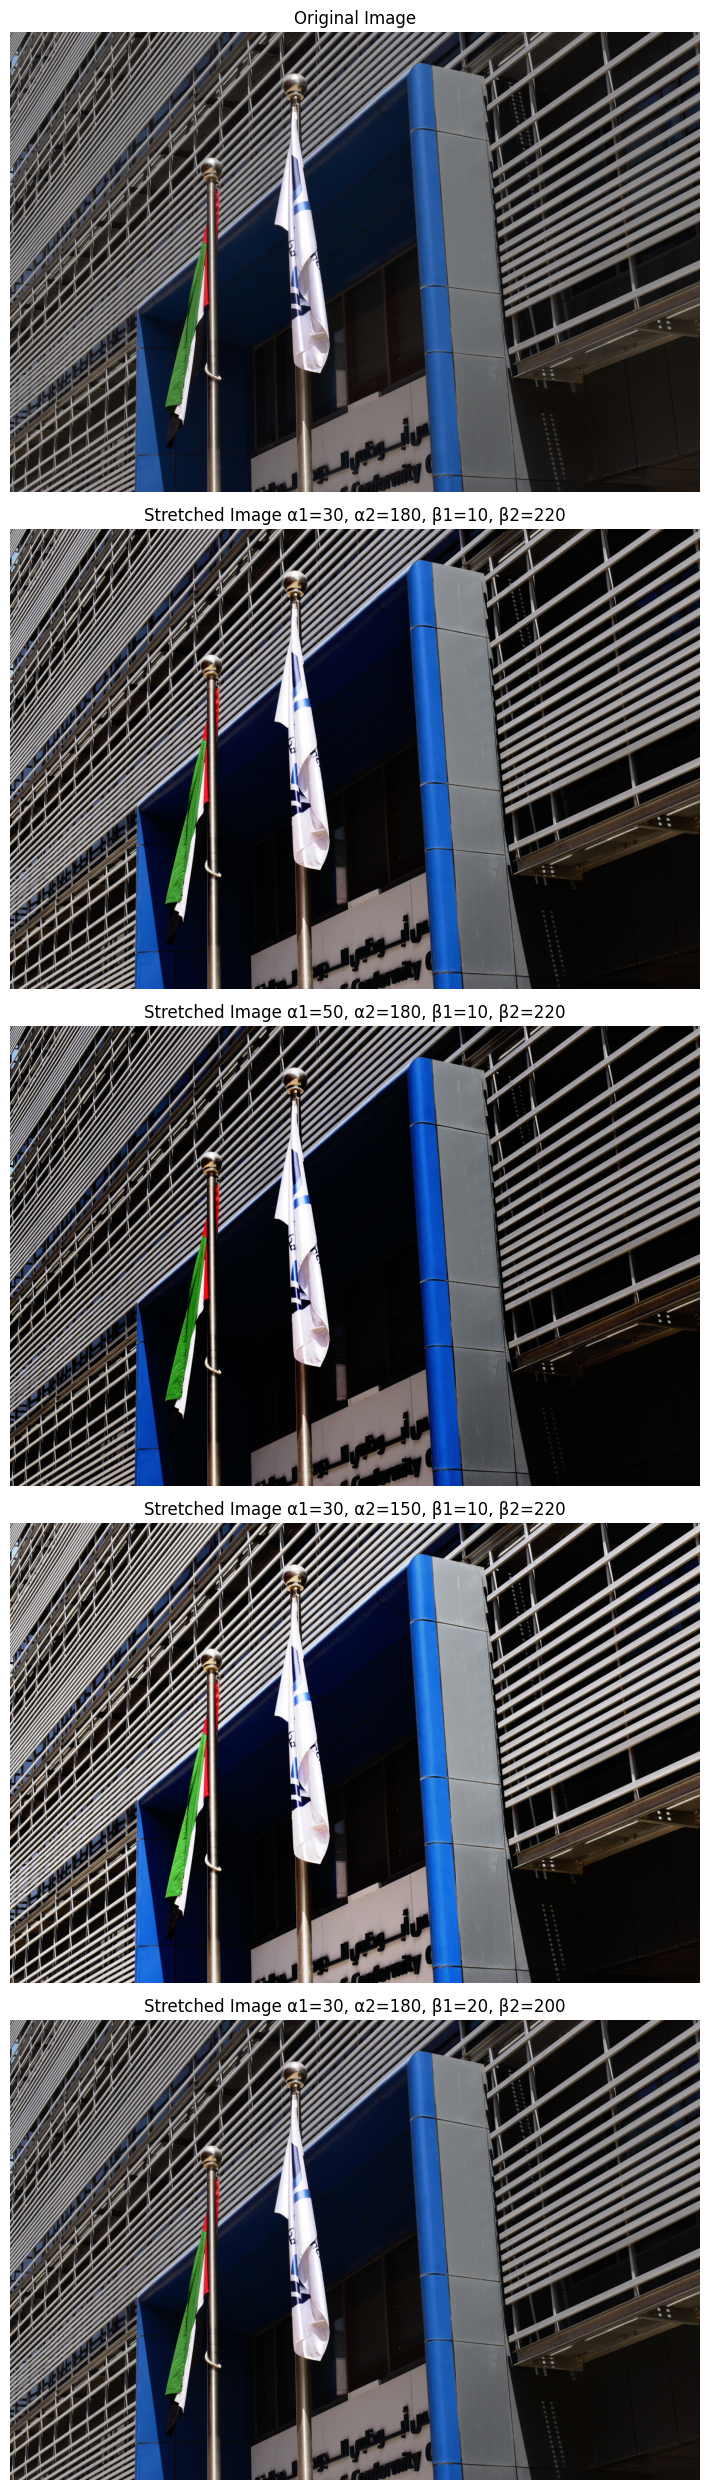

In [14]:
alphas = [(30, 180), (50, 180), (30, 150), (30, 180)]
betas = [(10, 220), (10, 220), (10, 220), (20, 200)]

plt.figure(figsize=(10, 25))
plt.subplot(len(alphas) + 1, 1, 1)
plt.imshow(rgb_img)
plt.title('Original Image')
plt.axis('off')

for i, (alpha_pair, beta_pair) in enumerate(zip(alphas, betas)):
    a1, a2 = alpha_pair
    b1, b2 = beta_pair

    channels = cv2.split(rgb_img)
    cont_stretched_channels = [contrast_stretch(channel, a1, a2, b1, b2) for channel in channels]

    stretched_img_rgb = cv2.merge(cont_stretched_channels)

    plt.subplot(len(alphas) + 1, 1, i + 2)
    plt.imshow(stretched_img_rgb)
    plt.title(f'Stretched Image α1={a1}, α2={a2}, β1={b1}, β2={b2}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Contrast stretching after converting to YUV colour space**

In [21]:
yuv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)
Y, U, V = cv2.split(yuv_img)

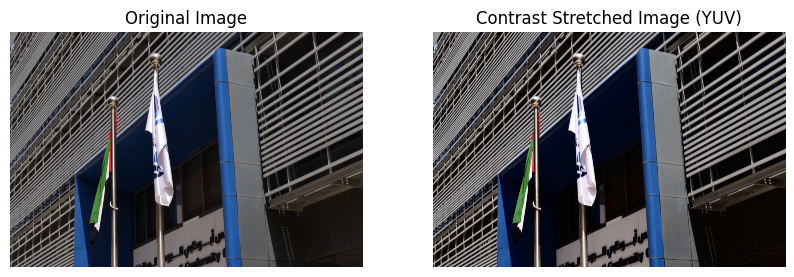

True

In [22]:
a1, a2 = 30, 180
b1, b2 = 10, 220

Y_stretched = contrast_stretch(Y, a1, a2, b1, b2)

stretched_yuv_img = cv2.merge([Y_stretched, U, V])

stretched_rgb_img = cv2.cvtColor(stretched_yuv_img, cv2.COLOR_YUV2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(stretched_rgb_img)
plt.axis('off')
plt.title('Contrast Stretched Image (YUV)')

plt.show()

stretched_bgr_img = cv2.cvtColor(stretched_rgb_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("data/stretched_image_yuv.png", stretched_bgr_img)